# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                # Sepparating each word from its embedding
                word, vec = line.split(' ', 1)
                # We add each word and its embedding to the word2vec attribute
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        key_list = []
        key_score = []
        # Creating an array with the cosine score for each word
        for key, value in self.word2vec.items():
            key_list.append(key)
            key_score.append( self.score(w, key) )
        # Sorting the words
        key_list = np.array(key_list)
        key_score = np.array(key_score)
        sorted_score = np.argsort( key_score )
        # 
        most_similar_list = key_list[sorted_score[(-K-1):-1]]
        return most_similar_list

    def score(self, w1, w2):
        # Calculating the cosine similarity: np.dot  -  np.linalg.norm
        cosine_similarity = ( np.dot(self.word2vec[w1], self.word2vec[w2]) ) / ( np.linalg.norm( self.word2vec[w1] ) * np.linalg.norm( self.word2vec[w2] ) )
        return cosine_similarity


In [4]:
# We set nmax to 100,000 to be able to reach paris
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['kitties' 'feline' 'kitten' 'kitty' 'cats']
['canine' 'doggie' 'Dog' 'puppy' 'dogs']
['canines' 'doggies' 'Dogs' 'pooches' 'dog']
['tokyo' 'berlin' 'london' 'Paris' 'france']
['poland' 'berlin' 'german' 'europe' 'austria']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        #
        shape = (300,)
        
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                word_list = sent.split(' ')
                mean = np.zeros(shape)
                int_num = 0
                for i in word_list:
                    if i in w2v.word2vec.keys():
                        mean += w2v.word2vec[i]
                        int_num += 1
                mean = mean / int_num
                sentemb.append(mean)
                #assert False, 'TODO: fill in the blank'
            else:
                # idf-weighted mean of word vectors
                word_list = sent.split(' ')
                mean = np.zeros(shape)
                int_num = 0
                for i in word_list:
                    if i in w2v.word2vec.keys():
                        mean += w2v.word2vec[i] * idf[i]
                        int_num += 1
                mean = mean / int_num
                sentemb.append(mean)
                #assert False, 'TODO: fill in the blank'
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        key_list = sentences
        key_score = []
         # Creating an array with the cosine score for each word
        for sent in sentences:
            key_score.append( self.score(s, sent, idf) )
        # Sorting the sentences
        key_list = np.array(key_list)
        key_score = np.array(key_score)
        sorted_score = np.argsort( key_score )
        # 
        most_similar_list = key_list[sorted_score[(-K-1):-1]]
        print(most_similar_list)
        return most_similar_list

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        cosine_similarity = ( np.dot( self.encode([s1], idf)[0], self.encode([s2], idf)[0]) ) / ( np.linalg.norm( self.encode([s1], idf)[0] ) * np.linalg.norm( self.encode([s2], idf)[0] ) )
        return cosine_similarity
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        length = len(sentences)
        for sent in sentences:
            word_list = sent.split(' ')
            for w in set(word_list):
                idf[w] = idf.get(w, 0) + 1
        for w in idf.keys():
            idf[w] = max(1, np.log10(length / (idf[w])))
        return idf


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
file = open( os.path.join(PATH_TO_DATA, 'sentences.txt'), 'r') 
sentences = file.readlines() 
sentences = [ x[:-2] for x in sentences]

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

# Build idf scores for each word
idf = s2v.build_idf(sentences)
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 100000 pretrained word vectors
['a girl in black hat holding an african american baby .'
 'an african american man is sitting .'
 'an afican american woman standing behind two small african american children .'
 'a little african american boy and girl looking up .'
 'an african american man smiling .']
0.5726258859719607
['a girl in black hat holding an african american baby .'
 'an afican american woman standing behind two small african american children .'
 'a little african american boy and girl looking up .'
 'an african american man is sitting .'
 'an african american man smiling .']
0.4751450875368781


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\** = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [11]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_en=Word2vec('data/wiki.en.vec',nmax=50000)
w2v_fr=Word2vec('data/wiki.fr.vec',nmax=50000)
wiki_en=w2v_en.word2vec
wiki_fr=w2v_fr.word2vec

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [35]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
# First, let us create a list of the common words
intersect = []
for item in wiki_en.keys( ):
    if item in wiki_fr.keys():
        intersect.append(item)

# Creation of X and Y
n = len(intersect)
m = wiki_fr['le'].shape[0]

X = np.zeros((n,m))
Y = np.zeros((n,m))

for i, item in enumerate(intersect):
    X[i:]= wiki_en[item]
    Y[i:]= wiki_fr[item]

print(X.shape)
print(Y.shape)

(18970, 300)
(18970, 300)


In [39]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
# We will use the transposed of X and Y for computational reasons
X_T = np.transpose(X)
Y_T = np.transpose(Y)

# Thanks to the procrustes, we can find the optimal solution for W thanks to the SVD(Y_T * X)
U, S, V_T = scipy.linalg.svd( (Y_T@X) )

# We have W* = U*V_T where U*S*V_T = SVD(Y_T * X)
W = U @ V_T

print(W.shape)

(300, 300)


In [57]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
# We need to calculate the transposed of W for our function
W_T = np.transpose(W)

def translated_nn( word, K, language = "French"):
    if language == "French":
        key_list = []
        key_score = []
        # Creating an array with the cosine score for each word
        for key, value in w2v_en.word2vec.items():
            key_list.append(key)
            new_coord = W_T @ w2v_fr.word2vec[word]
            cosine_similarity = ( np.dot(new_coord, w2v_en.word2vec[key]) ) / ( np.linalg.norm( new_coord ) * np.linalg.norm( w2v_en.word2vec[key] )) 
            key_score.append( cosine_similarity )
        # Sorting the words
        key_list = np.array(key_list)
        key_score = np.array(key_score)
        sorted_score = np.argsort( key_score )
        most_similar_list = key_list[sorted_score[(-K-1):-1]]
        return most_similar_list
    elif language == "English":
        key_list = []
        key_score = []
        # Creating an array with the cosine score for each word
        for key, value in w2v_fr.word2vec.items():
            key_list.append(key)
            new_coord = W @ w2v_en.word2vec[word]
            cosine_similarity = ( np.dot(new_coord, w2v_fr.word2vec[key]) ) / ( np.linalg.norm( new_coord ) * np.linalg.norm( w2v_fr.word2vec[key] )) 
            key_score.append( cosine_similarity )
        # Sorting the words
        key_list = np.array(key_list)
        key_score = np.array(key_score)
        sorted_score = np.argsort( key_score )
        most_similar_list = key_list[sorted_score[(-K-1):-1]]
        return most_similar_list
    else:
        print("Write 'French' or 'English' ")
        
french_words = ['chat', 'rideau', 'pomme', 'stylo']
english_words = ['dog', 'computer', 'bread', 'flower']

print("French words' nearest neighbors in English")
for item in french_words:
    print(item, translated_nn( item, K=5, language = "French"))

print('\n')
                                                                               
print("English words' nearest neighbors in French")
for item in english_words:
    print(item, translated_nn( item, K=5, language = "English"))                                                                            

French words' nearest neighbors in English
chat ['squirrel' 'poodle' 'feline' 'hamster' 'rabbit']
rideau ['windscreen' 'rideau' 'balcony' 'foyer' 'curtains']
pomme ['spinach' 'papaya' 'potatoes' 'potato' 'avocado']
stylo ['syringe' 'headset' 'ink' 'flashlight' 'typewriter']


English words' nearest neighbors in French
dog ['chicken' 'chienne' 'chiens' 'hound' 'chien']
computer ['informatiques' 'computing' 'ordinateur' 'ordinateurs' 'informatique']
bread ['saucisses' 'beurre' 'desserts' 'confiture' 'pains']
flower ['leaves' 'pétales' 'fleur' 'flowers' 'fleurs']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [79]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
PATH_TO_DATA_3 = "data/SST/"

sentences_train = []
results_train = []

with io.open(os.path.join(PATH_TO_DATA_3, 'stsa.fine.train'), encoding='utf-8', newline='\n') as f:
    next(f)
    for line in f:
        sentences_train.append(line[1:-1])
        results_train.append(int(line[:1]))
        
sentences_test = []

with io.open(os.path.join(PATH_TO_DATA_3, 'stsa.fine.test.X'), encoding='utf-8', newline='\n') as f:
    next(f)
    for line in f:
        sentences_test.append(line[:-1])
        
sentences_dev = []
results_dev = []

with io.open(os.path.join(PATH_TO_DATA_3, 'stsa.fine.dev'), encoding='utf-8', newline='\n') as f:
    next(f)
    for line in f:
        sentences_dev.append(line[1:-1])
        results_dev.append(int(line[:1]))

In [81]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE 
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

encoded_train = s2v.encode(sentences_train)
encoded_test = s2v.encode(sentences_test)
encoded_dev = s2v.encode(sentences_dev)

# Let us also encode with the idf
idf_train = s2v.build_idf(sentences_train)
idf_test = s2v.build_idf(sentences_test)
idf_dev = s2v.build_idf(sentences_dev)

encoded_train_idf = s2v.encode(sentences_train, idf_train)
encoded_test_idf = s2v.encode(sentences_test, idf_test)
encoded_dev_idf = s2v.encode(sentences_dev, idf_dev)

Loaded 100000 pretrained word vectors


In [82]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params_logreg = {'fit_intercept':(True, False), 'C':np.logspace(-3,3,7)}

logreg = LogisticRegression(random_state=8, solver='lbfgs', multi_class='multinomial', max_iter=1000)
logreg_cv = GridSearchCV(logreg, params_logreg, cv=5)
logreg_cv.fit(encoded_train, results_train)

print("Tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("Train accuracy with no idf:",logreg_cv.score(encoded_train,results_train))
print("Dev accuracy with no idf:",logreg_cv.score(encoded_dev,results_dev))

logreg_idf= LogisticRegression(random_state=8, C=1, solver='lbfgs', multi_class='multinomial', max_iter=1000)
logreg_idf.fit(encoded_train_idf, results_train)
print("Train accuracy with idf:",logreg_idf.score(encoded_train_idf,results_train))
print("Dev accuracy with idf:",logreg_idf.score(encoded_dev_idf,results_dev))

Tuned hyperparameters :(best parameters)  {'C': 1.0, 'fit_intercept': False}
Train accuracy with no idf: 0.4993561980568887
Dev accuracy with no idf: 0.43272727272727274
Train accuracy with idf: 0.497600374575676
Dev accuracy with idf: 0.4090909090909091


In [140]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
results_test_1 = logreg_cv.predict(encoded_test)

file = open("logreg_bov_y_test_sst.txt","w") 

for i in results_test_1:
    file.write(str(i)) 
    file.write("\n")

file.close() 

In [70]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

params_svc = { 'C':np.logspace(-3,3,7),'degree': range(1,6), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svc=SVC(random_state = 8, gamma='auto')
svc_cv = RandomizedSearchCV(svc, params_svc, cv=5)
svc_cv.fit(encoded_train, results_train)

print("Tuned hyperparameters :(best parameters) ",svc_cv.best_params_)
print("Accuracy :",svc_cv.best_score_)

#After fitting the randomized search, those were the best parameters
svc_2 = SVC(gamma = 'auto', random_state=8, C = 100 , degree = 3 , kernel = 'rbf' )
svc_2.fit(encoded_train, results_train)

print("Test score :", svc_2.score(encoded_dev, results_dev))

# Creating a file for the results of the test set
results_test_2 = svc_2.predict(encoded_test)

file = open("svc_bov_y_test_sst.txt","w") 

for i in results_test_2:
    file.write(str(i)) 
    file.write("\n")

file.close() 

Tuned hyperparameters : {'kernel': 'rbf', 'degree': 3, 'C': 100}
Accuracy : 0.4892894767646026
Test score : 0.43363636363636365


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [71]:
import keras

Using TensorFlow backend.


In [72]:
# 1 - Load train/dev/test sets of SST

# TYPE CODE HERE
PATH_TO_DATA_3 = "data/SST/"

sentences_train = []
results_train = []

with io.open(os.path.join(PATH_TO_DATA_3, 'stsa.fine.train'), encoding='utf-8', newline='\n') as f:
    next(f)
    for line in f:
        sentences_train.append(line[1:-1])
        results_train.append(int(line[:1]))
        
sentences_test = []

with io.open(os.path.join(PATH_TO_DATA_3, 'stsa.fine.test.X'), encoding='utf-8', newline='\n') as f:
    next(f)
    for line in f:
        sentences_test.append(line[:-1])
        
sentences_dev = []
results_dev = []

with io.open(os.path.join(PATH_TO_DATA_3, 'stsa.fine.dev'), encoding='utf-8', newline='\n') as f:
    next(f)
    for line in f:
        sentences_dev.append(line[1:-1])
        results_dev.append(int(line[:1]))

In [73]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE

# Finding the vocab size : We split each sentence into words for the three sets of text
all_text = (sentences_dev+ sentences_test + sentences_train)
from keras.preprocessing.text import text_to_word_sequence
a = []
for line in all_text:
        a.append(text_to_word_sequence(line))
# We then flatten it to get a final list of all words, and use "set" to count the unique words
flat_list = [item for sublist in a for item in sublist]
vocab_size = len(set(flat_list))

n = vocab_size

# We then transform the text into integers (word indexes) thanks to the one_hot preprocessing function
one_hot_train = []
one_hot_test = []
one_hot_dev = []

from keras.preprocessing.text import one_hot

for sent in sentences_train:
    one_hot_train.append( one_hot(sent, n, lower=True, split=' '))
    
for sent in sentences_test:
    one_hot_test.append( one_hot(sent, n, lower=True, split=' '))
    
for sent in sentences_dev:
    one_hot_dev.append( one_hot(sent, n, lower=True, split=' '))

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [74]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

# To get maxlen, we ran the padding once and then used tha maximum shape[0] of our three sets

pad_train = pad_sequences(one_hot_train, maxlen = 52)
pad_test = pad_sequences(one_hot_test, maxlen = 52)
pad_dev = pad_sequences(one_hot_dev, maxlen = 52)

## 4.2 - Design and train your model

In [75]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation



embed_dim  = 52 # word embedding dimension
nhid       = 256  # number of hidden units in the LSTM
vocab_size = vocab_size #100000  # size of the vocabulary found previously
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


C:\Users\juann\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, dropout=0.2, recurrent_dropout=0.2)`


In [76]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from keras.optimizers import Adam

loss_classif     =  'categorical_crossentropy' # We selected this classifier since it it a multiclass probelm
optimizer        =  'adam' # We used the Adam optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 52)          927524    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               316416    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,245,225
Trainable params: 1,245,225
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\juann\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8543 samples, validate on 1100 samples
Epoch 1/2
8543/8543 [==============================] - 196s 23ms/step - loss: 1.5691 - acc: 0.2871 - val_loss: 1.5206 - val_acc: 0.3373
Epoch 2/2
8543/8543 [==============================] - 180s 21ms/step - loss: 1.3750 - acc: 0.3926 - val_loss: 1.4076 - val_acc: 0.3836


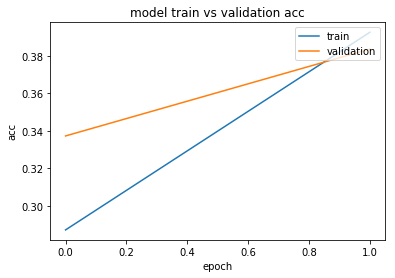

In [125]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 32
#We take 2 epochs to avoid overfitting
n_epochs = 2

# We used the dev set as validation set
x_train = pad_train
y_train_1 = results_train
x_val = pad_dev
y_val_1 = results_dev

# Transforming our results into categorical data
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train_1, 5)
y_val = np_utils.to_categorical(y_val_1, 5)

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_val, y_val))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [126]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
x_test = pad_test

results_test_3 = model.predict(x_test)
argmax_3 = np.argmax(results_test_3, axis = 1)

file = open("logreg_lstm_y_test_sst.txt","w") 

for i in argmax_3:
    file.write(str(i)) 
    file.write("\n")

file.close() 

## 4.3 -- innovate !

In [93]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

# I decided to use another encoder. I used the Tokenizer function to preprocess the text.
# Each input line would therefore have a size (,vocab_size) instead of (,52).
# This higher dimension might lead to enhanced prediction.

from keras.preprocessing.text import Tokenizer

t = Tokenizer()

# fit the tokenizer on the train text
t.fit_on_texts(sentences_train+sentences_dev+sentences_test)

# integer encode documents
token_train = t.texts_to_matrix(sentences_train, mode='count')
token_test = t.texts_to_matrix(sentences_test, mode='count')
token_dev = t.texts_to_matrix(sentences_dev, mode='count')

# We will use dev set as validation set
x_train = token_train
y_train_1 = results_train
x_val = token_dev
y_val_1 = results_dev

# Transforming reluts into categorical data
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train_1, 5)
y_val = np_utils.to_categorical(y_val_1, 5)

# I used a classical dense NN, which improved the previous results. 
# Any attempt to perform a Conv1D or an LSTM lead to a very high computational time, and no extra performance.

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import regularizers

model_dnn = Sequential()
model_dnn.add(Dense(64, input_shape=(x_train.shape[1],), activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(128, activation='relu'))
model_dnn.add(Dropout(0.2))

model_dnn.add(Dense(5))
model_dnn.add(Activation('softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_dnn.metrics_names)

# To avoid overfitting, I had to use only one epoch, since the model converges fast
batch_size = 16
epochs = 1

history = model_dnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model_dnn.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
print('Validation accuracy:', score[1])


# Let us now predict the results and store those
x_test = token_test

results_test_4 = model_dnn.predict(x_test)
argmax_4 = np.argmax(results_test_4, axis = 1)

file = open("tokenized_denseNN_y_test_sst.txt","w") 

for i in argmax_4:
    file.write(str(i)) 
    file.write("\n")

file.close() 

['loss', 'acc']
Train on 7688 samples, validate on 855 samples
Epoch 1/1
1100/1100 [==============================] - 1s 1ms/step
Validation accuracy: 0.4118181819265539
